### **Library Importation**

In [1]:
# installing keras-tuner
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [18]:
# Imports
import keras
from keras.datasets import fashion_mnist
from keras import layers
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import kerastuner as kt
import seaborn as sns

import os
seed = 100
os.environ['PYTHONHASHSEED']=str(seed)
keras.utils.set_random_seed(seed)

In [72]:
# load in the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# make sure that the data is all the right shape
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)



In [29]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

Train Dataset


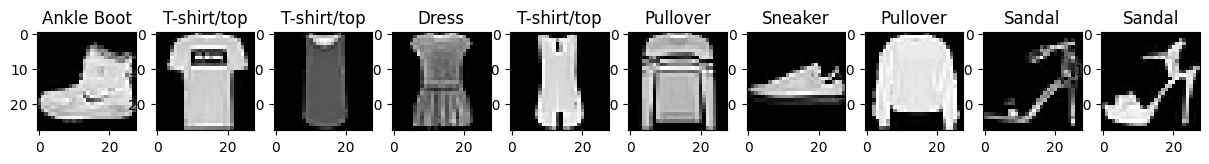

Test set


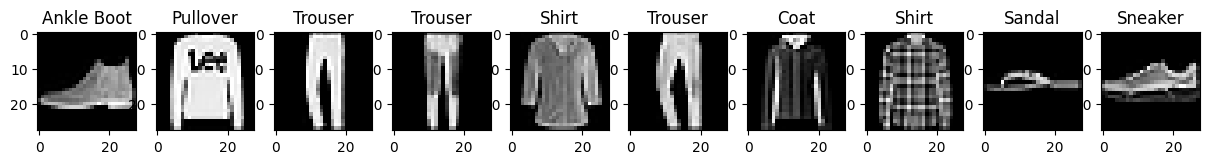

In [32]:
# Plot the images
plt.figure(figsize=[15, 5])
print('Train Dataset')

# Display the first 5 images in the training data
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i, :, :], cmap='gray')
    plt.title(labels[y_train[i]])

plt.show()

# Plot the images for the test set
print('Test set')
plt.figure(figsize=[15, 5])

# Display the first 10 images in the testing data
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[i, :, :], cmap='gray')
    plt.title(labels[y_test[i]])

plt.show()

In [73]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One hot encode the output data
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### **Data Augmentation**

In [74]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


import numpy as np
# Generate aungmented images for the training data
x_train = np.reshape(x_train, (60000,28,28,1))
training_set = train_gen.flow(x_train, y_train, batch_size=x_train.shape[0])

# Generate aungmented images for the test data
x_test = np.reshape(x_test, (10000,28,28,1))
test_set= train_gen.flow(x_test, y_test, batch_size=x_test.shape[0])

# extract the augmented images from the output flow of the generator
# add the augmented images generated from the training data to the original training data
i = 0
for x, y in training_set:
  if i < 2:
    print(i)
    x_train = np.concatenate((x_train, x))
    y_train = np.concatenate((y_train, y))
    print(x_train.shape)
    print(y_train.shape)
  else:
    break
  i += 1

# add the augmented images generated from the test data to the original test data
i = 0
for x, y in test_set:
  if i < 2:
    print(i)
    x_test_aug = np.concatenate((x_test, x))
    y_test_aug = np.concatenate((y_test, y))
    print(x_test.shape)
    print(y_test.shape)
  else:
    break
  i += 1

0
(120000, 28, 28, 1)
(120000, 10)
1
(180000, 28, 28, 1)
(180000, 10)
0
(10000, 28, 28, 1)
(10000, 10)
1
(10000, 28, 28, 1)
(10000, 10)


### **Hyperparameter Tuning**

In [5]:
def model_builder(hp):
  model = tf.keras.Sequential()
  hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
  hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(hp_dropout))
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(hp_dropout2))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(units=10, activation='softmax'))

  # set the optimiser in the compile method
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3,           # factor is a number that determines how many models are created to run in parallel whaen testing the hyperparameters
                     directory = 'my_dir', # directory that the tuned hyperparameter results are stored in (change the name of this directory if you get the message INFO:tensorflow:Oracle triggered exit)
                     project_name = 'intro_to_kt')

In [7]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [8]:
import IPython
# run the hyperparameter search
tuner.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()])

Trial 30 Complete [00h 09m 06s]
val_accuracy: 0.8655999898910522

Best val_accuracy So Far: 0.8671000003814697
Total elapsed time: 01h 59m 41s


In [9]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'dropout': 0.30000000000000004, 'dropout2': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [17]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               401920    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

### **Model 1**

In [11]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(224, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

In [12]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs = 50, validation_data = (x_test, y_test))

Epoch 1/50
5625/5625 [==============================] - 32s 5ms/step - loss: 0.7897 - accuracy: 0.6958 - val_loss: 0.4593 - val_accuracy: 0.8283
Epoch 2/50
5625/5625 [==============================] - 29s 5ms/step - loss: 0.6398 - accuracy: 0.7555 - val_loss: 0.4254 - val_accuracy: 0.8450
Epoch 3/50
5625/5625 [==============================] - 31s 6ms/step - loss: 0.5967 - accuracy: 0.7717 - val_loss: 0.4120 - val_accuracy: 0.8468
Epoch 4/50
5625/5625 [==============================] - 31s 5ms/step - loss: 0.5699 - accuracy: 0.7828 - val_loss: 0.3809 - val_accuracy: 0.8550
Epoch 5/50
5625/5625 [==============================] - 30s 5ms/step - loss: 0.5532 - accuracy: 0.7898 - val_loss: 0.3791 - val_accuracy: 0.8604
Epoch 6/50
5625/5625 [==============================] - 31s 6ms/step - loss: 0.5393 - accuracy: 0.7947 - val_loss: 0.3754 - val_accuracy: 0.8565
Epoch 7/50
5625/5625 [==============================] - 29s 5ms/step - loss: 0.5277 - accuracy: 0.7996 - val_loss: 0.3590 - val_ac

In [85]:
keras.backend.clear_session()

# set random seed
keras.utils.set_random_seed(seed)

### **Model 2**

In [76]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))


In [77]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size=60, epochs = 25, validation_data = (x_test, y_test))

Epoch 1/25
3000/3000 [==============================] - 11s 3ms/step - loss: 0.8235 - accuracy: 0.6833 - val_loss: 0.4691 - val_accuracy: 0.8297
Epoch 2/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6580 - accuracy: 0.7493 - val_loss: 0.4222 - val_accuracy: 0.8465
Epoch 3/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6156 - accuracy: 0.7651 - val_loss: 0.4064 - val_accuracy: 0.8536
Epoch 4/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5898 - accuracy: 0.7757 - val_loss: 0.3890 - val_accuracy: 0.8564
Epoch 5/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5720 - accuracy: 0.7827 - val_loss: 0.3728 - val_accuracy: 0.8614
Epoch 6/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5566 - accuracy: 0.7889 - val_loss: 0.3761 - val_accuracy: 0.8651
Epoch 7/25
3000/3000 [==============================] - 9s 3ms/step - loss: 0.5450 - accuracy: 0.7926 - val_loss: 0.3713 - val_accuracy

### **Model 3**

In [86]:
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [87]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size=60, epochs = 25, validation_data = (x_test, y_test))

Epoch 1/25
3000/3000 [==============================] - 13s 4ms/step - loss: 0.7980 - accuracy: 0.7066 - val_loss: 0.4697 - val_accuracy: 0.8297
Epoch 2/25
3000/3000 [==============================] - 12s 4ms/step - loss: 0.5682 - accuracy: 0.7945 - val_loss: 0.4154 - val_accuracy: 0.8524
Epoch 3/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5033 - accuracy: 0.8173 - val_loss: 0.3964 - val_accuracy: 0.8570
Epoch 4/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4721 - accuracy: 0.8296 - val_loss: 0.3653 - val_accuracy: 0.8687
Epoch 5/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4518 - accuracy: 0.8373 - val_loss: 0.3614 - val_accuracy: 0.8695
Epoch 6/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4319 - accuracy: 0.8441 - val_loss: 0.3485 - val_accuracy: 0.8721
Epoch 7/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4201 - accuracy: 0.8484 - val_loss: 0.3505 - val_ac

### **Model 3**

In [83]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [84]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size=60, epochs = 25, validation_data = (x_test, y_test))

Epoch 1/25
3000/3000 [==============================] - 13s 4ms/step - loss: 0.8647 - accuracy: 0.6822 - val_loss: 0.5100 - val_accuracy: 0.8138
Epoch 2/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.6106 - accuracy: 0.7813 - val_loss: 0.4304 - val_accuracy: 0.8418
Epoch 3/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5391 - accuracy: 0.8082 - val_loss: 0.4113 - val_accuracy: 0.8568
Epoch 4/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5023 - accuracy: 0.8222 - val_loss: 0.3713 - val_accuracy: 0.8657
Epoch 5/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4749 - accuracy: 0.8320 - val_loss: 0.3770 - val_accuracy: 0.8607
Epoch 6/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4532 - accuracy: 0.8400 - val_loss: 0.3437 - val_accuracy: 0.8762
Epoch 7/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4341 - accuracy: 0.8457 - val_loss: 0.3489 - val_ac

### **Model 4**

In [80]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 576)              

In [41]:
# training the model
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train, y_train, batch_size=60, epochs = 25, validation_data = (x_test, y_test))

Epoch 1/25
3000/3000 [==============================] - 12s 4ms/step - loss: 0.7854 - accuracy: 0.7111 - val_loss: 0.4396 - val_accuracy: 0.8416
Epoch 2/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.5472 - accuracy: 0.8014 - val_loss: 0.3404 - val_accuracy: 0.8791
Epoch 3/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4714 - accuracy: 0.8300 - val_loss: 0.3282 - val_accuracy: 0.8836
Epoch 4/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.4327 - accuracy: 0.8447 - val_loss: 0.3206 - val_accuracy: 0.8888
Epoch 5/25
3000/3000 [==============================] - 10s 3ms/step - loss: 0.4040 - accuracy: 0.8548 - val_loss: 0.2920 - val_accuracy: 0.8984
Epoch 6/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.3835 - accuracy: 0.8616 - val_loss: 0.2782 - val_accuracy: 0.9012
Epoch 7/25
3000/3000 [==============================] - 11s 4ms/step - loss: 0.3682 - accuracy: 0.8669 - val_loss: 0.2841 - val_ac

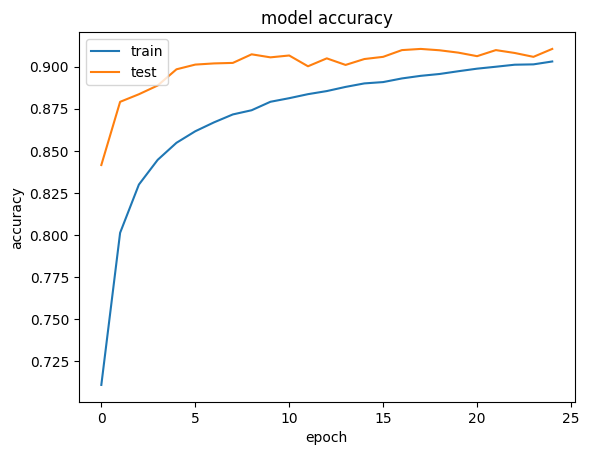

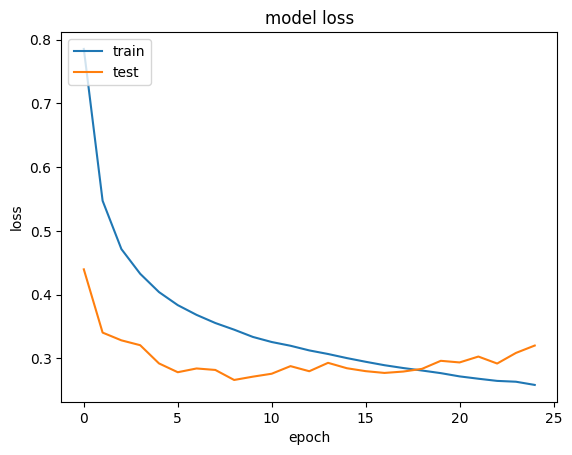

In [43]:
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [68]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.3087417185306549
Train accuracy: 0.8951277732849121
